# Full example

In [1]:
push!(LOAD_PATH,"C:/JMB/DINEOF.jl/src","."); using DINEOF
using PyPlot
using LinearAlgebra
using Arpack
using Statistics
using Optim
using NCDatasets
using FTPClient

## Get a nice data cube and look at it

In [2]:
fname="c:/Users/JMBECKERS/Downloads/SPMCT.nc"


"c:/Users/JMBECKERS/Downloads/SPMCT.nc"

In [3]:
ds=Dataset(fname)

Dataset: c:\Users\JMBECKERS\Downloads\SPMCT.nc
Group: /

Dimensions
   time = 366
   lat = 124
   lon = 115

Variables
  time   (366)
    Datatype:    Float64
    Dimensions:  time
    Attributes:
     units                = seconds since 1970-1-1
     calendar             = gregorian
     standard_name        = time

  coverage   (366)
    Datatype:    Float64
    Dimensions:  time
    Attributes:
     long_name            = Percentage of valid pixels
     valid_min            = 0.0
     valid_max            = 100.0

  lat   (124)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     units                = degrees north
     standard_name        = latitude

  lon   (115)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     units                = degrees east
     standard_name        = longitude

  spm   (115 × 124 × 366)
    Datatype:    Float64
    Dimensions:  lon × lat × time
    Attributes:
     _FillValue           = -999.0
     units                = 

In [4]:
spm=ds["logspm"][:]
spm[ismissing.(spm)].=NaN

3495799-element view(reshape(::Array{Union{Missing, Float64},3}, 5219160), [1, 57, 58, 59, 60, 61, 62, 63, 75, 116  …  5219151, 5219152, 5219153, 5219154, 5219155, 5219156, 5219157, 5219158, 5219159, 5219160]) with eltype Union{Missing, Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [5]:
meanspm=mean(spm[.!isnan.(spm)])

0.3915928944267166

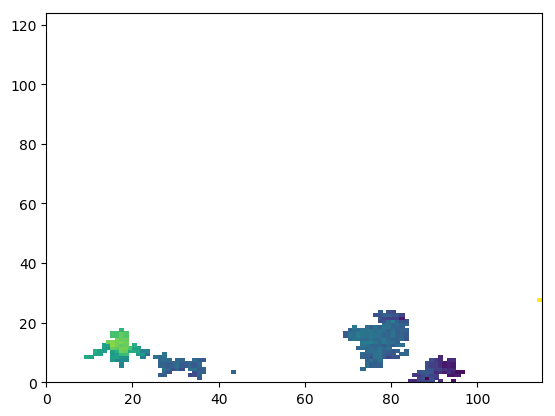

PyObject <matplotlib.collections.PolyCollection object at 0x0000000035513668>

In [6]:
pcolor(spm[:,:,10]')

## Make a first analysis with only a limited number of EOFs

Raw data variance and mean: 0.19450120556381156 and 0.3915928944267166
Number of missing points (including possible masks): 3495799 out of 5219160
Number of data points before elimination of low coverage regions is 1723361 and cv fraction 0.010176045529636565
Number of data points after elimination of low coverage regions is 1654024 and cv fraction 0.010159465642578342
(mean(X2D), meanmatrix, meanmiss, datamean) = (-0.00015187440959048043, -0.0042555044451988875, -0.0003407491102101289, 0.3915928944267166)
svds! matrix size: (11611, 257)
svds!: variance and mean of the entry matrix: 0.19318599384767945 , -0.00015187440959048043 ; intial variance at points to fill in: 0.19321009482483767 
Eof loop 1 with root mean squared misfit: 0.3027862343658329 
Eof loop 2 with root mean squared misfit: 0.15859326635120413 
Eof loop 3 with root mean squared misfit: 0.14343687580444747 
Eof loop 4 with root mean squared misfit: 0.13529371747337812 
Convergence for 5 eofs, relative change 0.0048548473

┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.0116730189014003
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:295


musquare optimization: Both OI-EOF error and CV coherence
tutu = Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.005091, 1.018268]
 * Minimizer: 1.006668e+00
 * Minimum: 4.964967e+02
 * Iterations: 8
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-02*|x|+1.0e-07): true
 * Objective Function Calls: 9
CV estimator from EOF 0.011763049639517452 is now 0.00989219555111793 if OI is used
Optimal musquare is 1.0066681432809808
Relative error on reconstruction 2.3938907590214355e-5, relative error on CV estimator 0.02529530819815992
The two criteria to compare OI and EOF are: reconstruction 71.43434659970457, closest CV 425.06235896187934
Estimated musquare 0.010182677453071035 was inflated by factor 98.86084950843411 into 1.0066681432809808
This optimal value provides OI interpolation CV estimator 0.00989219555111793
Mean error variance of reconstruction: 0.0055321290503917726 
562.110548 seconds (3.98 G allocations: 249.876 GiB, 8.09% gc tim

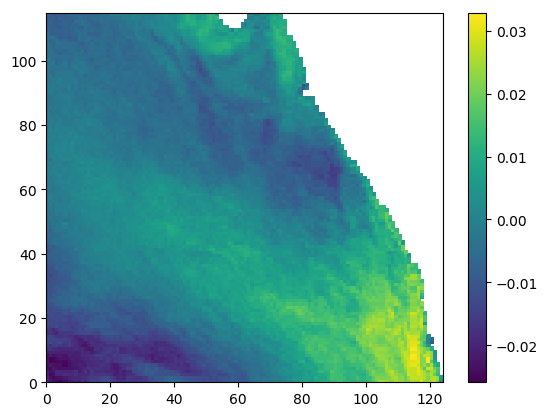

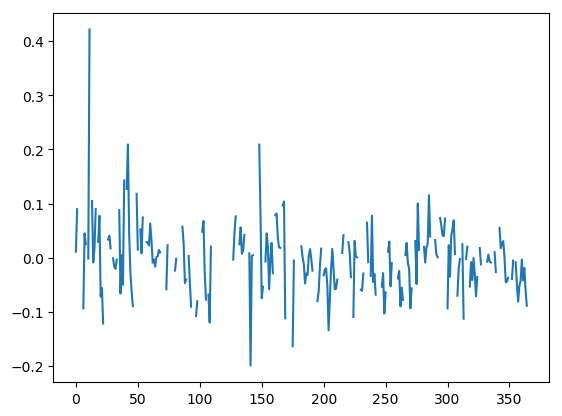

(S, sum(S .^ 2), offset) = ([563.5860402688422, 458.7997995093113, 125.50449284576757, 111.35547787542234, 92.56815931265511, 83.37173745189419, 62.570343944281575, 58.957837460449795, 48.428132175617634, 40.834085765017775], 583201.3928029174, 0.3873373899815177)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000356D1828>

In [7]:
@time XA,offset,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spm,[1,1,2];eofmax=10)
@show S,sum(S.^2),offset

pcolor(U[:,:,4]),colorbar()
figure()
plot(V[:,4])

Raw data variance and mean: 0.19450120556381156 and 0.3915928944267166
Number of missing points (including possible masks): 3495799 out of 5219160
Number of data points before elimination of low coverage regions is 1723361 and cv fraction 0.010153995593494341
Number of data points after elimination of low coverage regions is 1675065 and cv fraction 0.01014408396092092
(mean(X2D), meanmatrix, meanmiss, datamean) = (0.00020717398333990639, -0.005938301575889009, 0.000467751731618897, 0.3915928944267166)
svds! matrix size: (25921, 116)
svds!: variance and mean of the entry matrix: 0.19215093859113175 , 0.00020717398333990639 ; intial variance at points to fill in: 0.1919507054846532 
Eof loop 1 with root mean squared misfit: 0.2865113516560864 
Eof loop 2 with root mean squared misfit: 0.15715603348466003 
Eof loop 3 with root mean squared misfit: 0.11612473786230651 
Eof loop 4 with root mean squared misfit: 0.10400920959198637 
Eof loop 5 with root mean squared misfit: 0.097618853687236

┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.313025482667743
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:295



tutu = Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.002611, 0.522219]
 * Minimizer: 5.162701e-01
 * Minimum: 6.960300e+02
 * Iterations: 8
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-02*|x|+1.0e-07): true
 * Objective Function Calls: 9
CV estimator from EOF 0.0071084761221896185 is now 0.0056729655600418006 if OI is used
Optimal musquare is 0.5162701252130907
Relative error on reconstruction 1.023076652919356e-6, relative error on CV estimator 0.04078117800851634
The two criteria to compare OI and EOF are: reconstruction 3.0762237107574246, closest CV 692.9537767207097
Estimated musquare 0.005222189360754762 was inflated by factor 98.86085883689101 into 0.5162701252130907
This optimal value provides OI interpolation CV estimator 0.0056729655600418006
Mean error variance of reconstruction: 0.0005849604185125076 

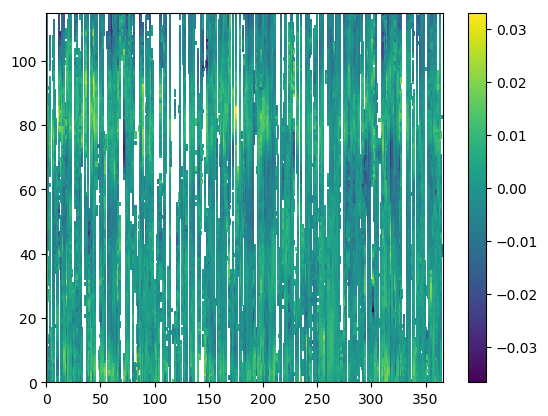

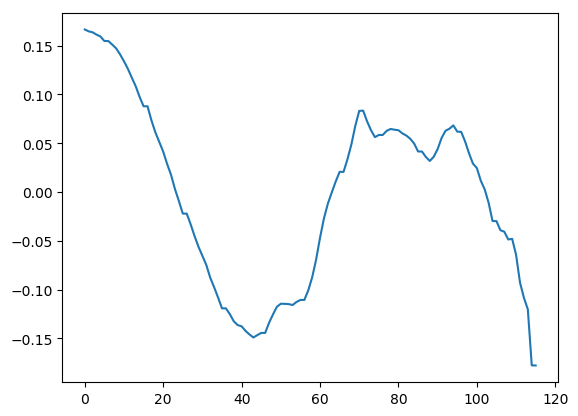


581.873957 seconds (4.22 G allocations: 275.349 GiB, 7.58% gc time)
(S, sum(S .^ 2), offset) = ([679.5239823663335, 443.0913865345212, 254.07525791433278, 112.76823787205167, 87.32833086334917, 77.30918154232465, 66.66726576755259, 49.12538696379891, 43.199706204890695, 30.67950574342307], 758621.9531693248, 0.3856545928508276)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000002289860>

In [8]:
@time XA,offset,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spm,[1,2,1];eofmax=10)
@show S,sum(S.^2),offset

pcolor(U[:,:,4]),colorbar()
figure()
plot(V[:,4])

Raw data variance and mean: 0.19450120556381156 and 0.3915928944267166
Number of missing points (including possible masks): 3495799 out of 5219160
Number of data points before elimination of low coverage regions is 1723361 and cv fraction 0.010207959910895048
Number of data points after elimination of low coverage regions is 1684255 and cv fraction 0.010166512790521625
(mean(X2D), meanmatrix, meanmiss, datamean) = (-0.00014687907214647606, -0.0033927863128535873, -0.0003117392816410057, 0.3915928944267166)
svds! matrix size: (27694, 115)
svds!: variance and mean of the entry matrix: 0.1934108713893624 , -0.00014687907214647606 ; intial variance at points to fill in: 0.19329737695614568 
Eof loop 1 with root mean squared misfit: 0.2764347795794167 
Eof loop 2 with root mean squared misfit: 0.15679730828259503 
Eof loop 3 with root mean squared misfit: 0.1250384664440056 
Eof loop 4 with root mean squared misfit: 0.10993603753886672 
Eof loop 5 with root mean squared misfit: 0.1000225783

┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.3666508399039787
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:295



tutu = Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.002640, 0.527988]
 * Minimizer: 5.219739e-01
 * Minimum: 6.950365e+02
 * Iterations: 8
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-02*|x|+1.0e-07): true
 * Objective Function Calls: 9
CV estimator from EOF 0.007073944615454804 is now 0.005649397907628224 if OI is used
Optimal musquare is 0.5219739072500192
Relative error on reconstruction 1.9973364010061624e-7, relative error on CV estimator 0.04055366192067713
The two criteria to compare OI and EOF are: reconstruction 0.6361136943288436, closest CV 694.4003530677545
Estimated musquare 0.0052798844203449805 was inflated by factor 98.86085862764287 into 0.5219739072500192
This optimal value provides OI interpolation CV estimator 0.005649397907628224
Mean error variance of reconstruction: 0.00043690247463271624 

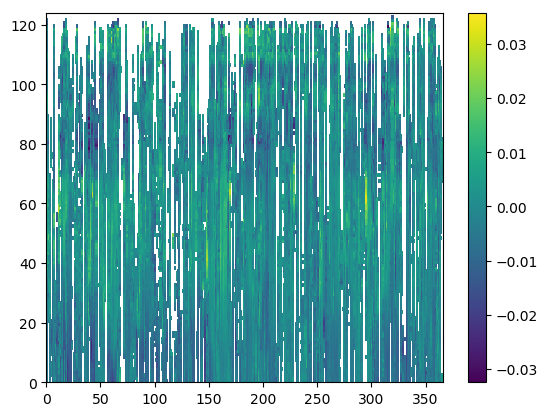

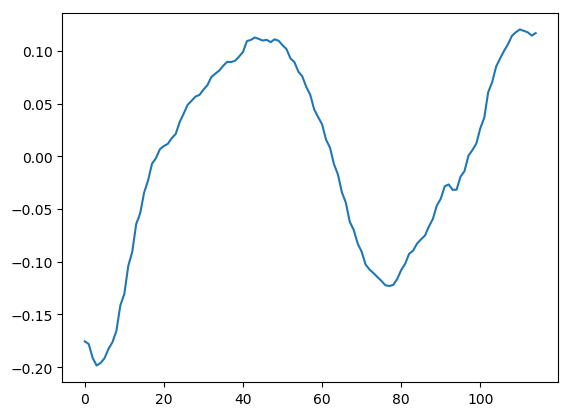


628.896620 seconds (4.69 G allocations: 304.168 GiB, 7.33% gc time)
(S, sum(S .^ 2), offset) = ([769.8278547398592, 401.8470527749778, 204.9757458994516, 128.73666235348423, 116.04035287766725, 77.519926897209, 59.056452499764205, 55.397383484023244, 45.08517339016396, 32.51526161353279], 841825.3167365337, 0.38820010811386296)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001F60CF8>

In [9]:
@time XA,offset,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spm,[2,1,1];eofmax=10)
@show S,sum(S.^2),offset

pcolor(U[:,:,4]),colorbar()
figure()
plot(V[:,4])

## Decide which directions to collapse and make a full analysis

In this example the classical space time decomposition seems to work. So lets try and add a time filter onto it with cross-validation by clouds.



Raw data variance and mean: 0.19450120556381156 and 0.3915928944267166
Number of missing points (including possible masks): 3495799 out of 5219160
Number of data points before elimination of low coverage regions is 1723361 and cv fraction 0.012217405407224604
Number of data points after elimination of low coverage regions is 1722351 and cv fraction 0.012197281506498965
(mean(X2D), meanmatrix, meanmiss, datamean) = (-4.421782319002966e-5, -0.0003997444572824378, -7.412296295038597e-5, 0.3915928944267166)
svds! matrix size: (11664, 366)
svds!: variance and mean of the entry matrix: 0.19407457933214237 , -4.421782319002966e-5 ; intial variance at points to fill in: 0.19394172135478752 
Eof loop 1 with root mean squared misfit: 0.2304962100104217 
Eof loop 2 with root mean squared misfit: 0.20335534763588373 
Convergence for 3 eofs, relative change 0.004797116010939007 after 9 iterations
Eof loop 3 with root mean squared misfit: 0.19470511577993635 
Convergence for 4 eofs, relative change 

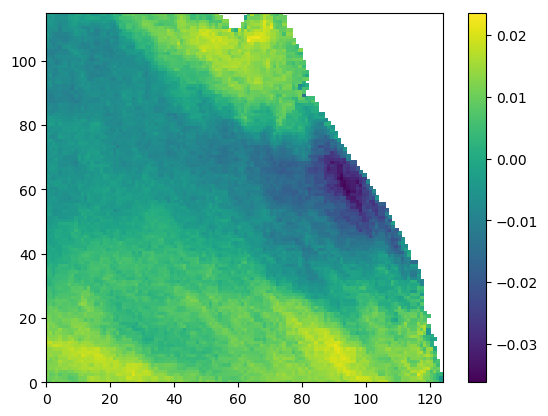

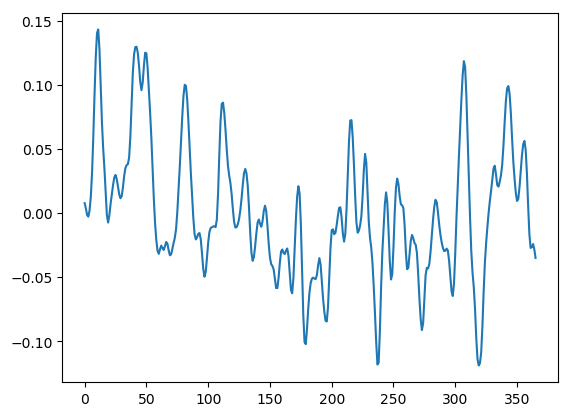

2164.406594 seconds (5.51 G allocations: 333.425 GiB, 2.63% gc time)
(S, sum(S .^ 2), offset) = ([668.5853704283986, 515.1131570373688, 118.08118839461305, 99.98951979805733, 77.63031276231109], 742315.4986855885, 0.39119314996943416)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003B333320>

In [10]:
@time XA,offset,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spm,[1,1,2];minimumcoverage=[0.05,0.01],filter="pmf",filterrepetitions=3,cvmethod="CopyMask",svdmeth="eig")
@show S,sum(S.^2),offset

pcolor(U[:,:,4]),colorbar()
figure()
plot(V[:,4])

## Apply QC and take out suspect points (put NaN)

In [11]:
OO=DINEOF_pmQC(spm,XA,errmap,musquare,4)
@show mean(OO[.!isnan.(OO)])

mean(OO[.!(isnan.(OO))]) = 0.4071603766341613


0.4071603766341613

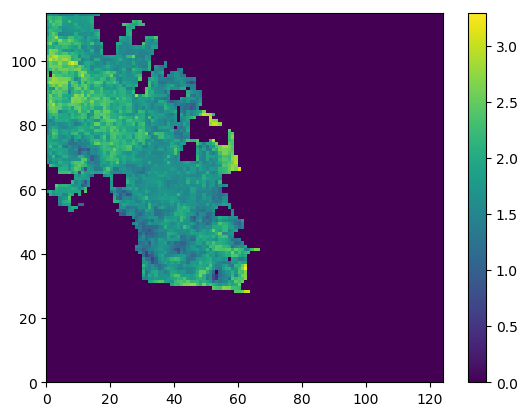

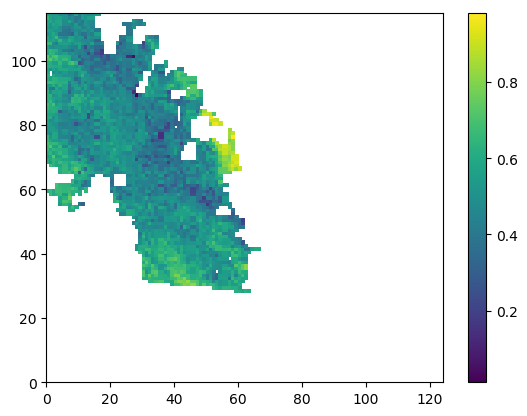

(PyObject <matplotlib.collections.PolyCollection object at 0x000000003F006400>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000005F8C9550>)

In [35]:
pcolor(OO[:,:,250]),colorbar()
figure()
pcolor(spm[:,:,250]),colorbar()

In [13]:
@show mean(XA[.!isnan.(XA)]),mean(spm[.!isnan.(spm)]),offset

(mean(XA[.!(isnan.(XA))]), mean(spm[.!(isnan.(spm))]), offset) = (0.44196775090826207, 0.3915928944267166, 0.39119314996943416)


(0.44196775090826207, 0.3915928944267166, 0.39119314996943416)

In [14]:
sum(OO.>5)/sum(.!isnan.(spm))*100

0.0015667059890527872

## Redo the decomposition but by restarting

With a time filter you can accept possibly empty images (so coverage for fixed time can be zero). But allow for more iterations for the final reconstruction and maybe use the pmf instead of vpmf

In [15]:
sum(isnan.(XA))

950136

In [16]:
prod(size(XA))

5219160

In [17]:
spmf=deepcopy(spm)
spmf[OO.>5].=NaN
@show sum(isnan.(spmf)),sum(isnan.(spm))
@time XA,offset,U,S,V,cvEOF,cvarray,errmap,musquare=DINEOFrun(spmf,[1,1,2];dineofmaxiter=20,restart=XA,eofstart=max(size(S)[1]-5,1),minimumcoverage=[0.05,0.01],filter="pmf",filterrepetitions=3,cvmethod="CopyMask",svdmeth="eig")
@show S,sum(S),offset

(sum(isnan.(spmf)), sum(isnan.(spm))) = (3495826, 3495799)
Raw data variance and mean: 0.19449803829981488 and 0.39159833383273995
Number of missing points (including possible masks): 3495826 out of 5219160
Number of data points before elimination of low coverage regions is 1723334 and cv fraction 0.014462663650807098
Using restart matrix
mean(restart2D[.!(isnan.(restart2D))]) = 0.05036941707552212
mean(restart2D[.!(isnan.(restart2D))]) = 0.04948209529430866
mean(restart2D[.!(isnan.(restart2D))]) = 0.04948209529430866
mean(restart2D[.!(isnan.(restart2D))]) = 0.05009424284358708
Number of data points after elimination of low coverage regions is 1718054 and cv fraction 0.012015920337777508
(mean(X2D), meanmatrix, meanmiss, datamean) = (0.050155282695206964, -0.0006121475492784251, 0.08409442663578637, 0.39159833383273995)
svds! matrix size: (11663, 365)
svds!: variance and mean of the entry matrix: 0.18443328554684213 , 0.050155282695206964 ; intial variance at points to fill in: 0.17593

┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:105


Eof loop 1 with root mean squared misfit: 0.3178247421674912 
Convergence for 2 eofs, relative change 0.004592438911459922 after 19 iterations
Eof loop 2 with root mean squared misfit: 0.21926817087362738 
Convergence for 3 eofs, relative change 0.004655568606898797 after 9 iterations
Eof loop 3 with root mean squared misfit: 0.20692439145692293 
Convergence for 4 eofs, relative change 0.0048972839148113765 after 10 iterations
Eof loop 4 with root mean squared misfit: 0.1993689841067977 
Convergence for 5 eofs, relative change 0.004856634048881268 after 8 iterations
Eof loop 5 with root mean squared misfit: 0.19445679099311147 
Convergence for 6 eofs, relative change 0.004753213726772736 after 11 iterations
Eof loop 6 with root mean squared misfit: 0.189272938988369 
Convergence for 7 eofs, relative change 0.004482270038410127 after 9 iterations
Eof loop 7 with root mean squared misfit: 0.18950623551717338 
Convergence for 8 eofs, relative change 0.0046186031654698485 after 8 iteration

([668.6444202092123, 505.877622775704, 123.18719989562805, 106.22085123570916, 96.95173126081161, 87.35464619578808, 72.12007304438093, 68.78474125320518, 58.06982770011159, 51.993348887335465, 48.0862448918675], 1887.2907073497538, 0.39098618628346155)

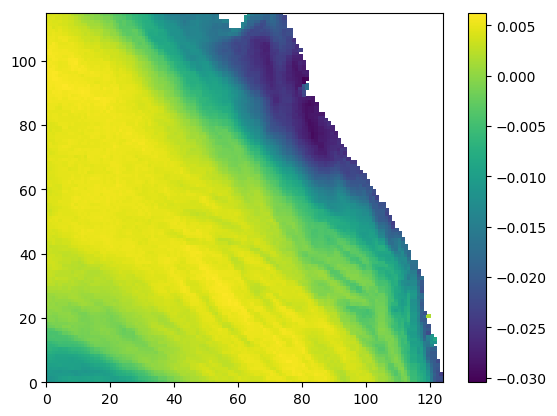

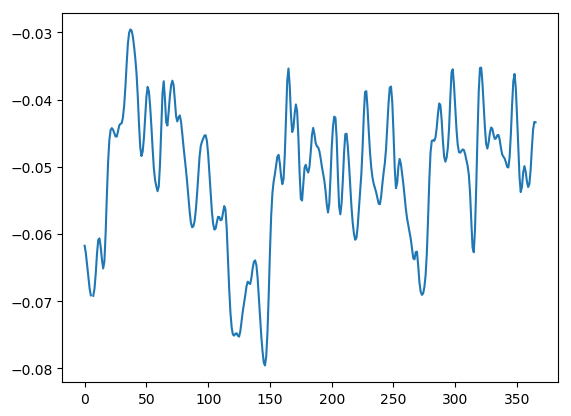

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000004E42128>

In [18]:
pcolor(U[:,:,1]),colorbar()
figure()
plot(V[:,1])

## Look at error field

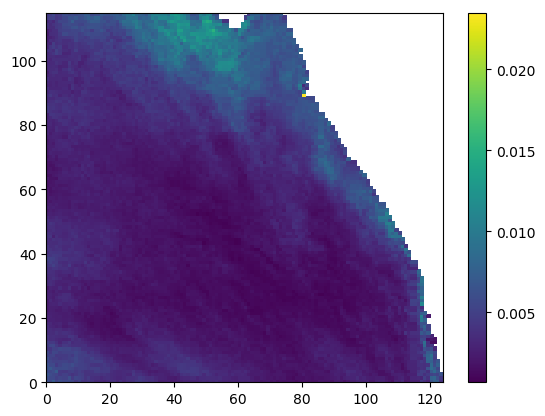

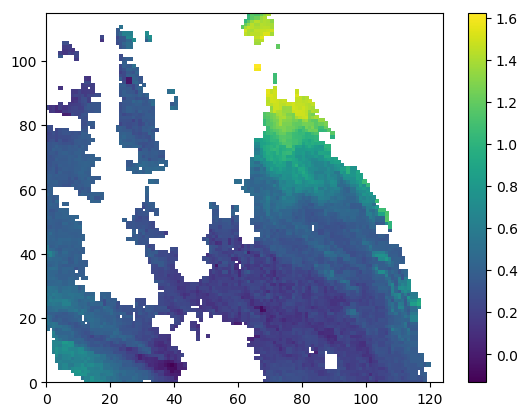

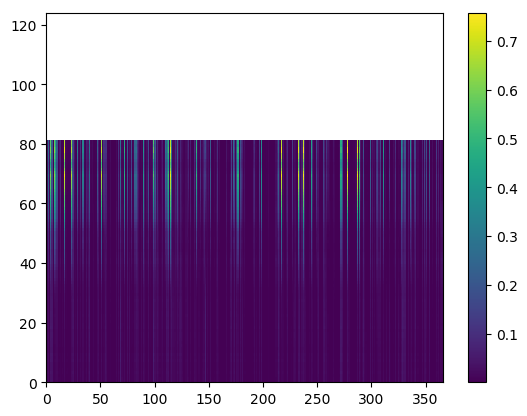

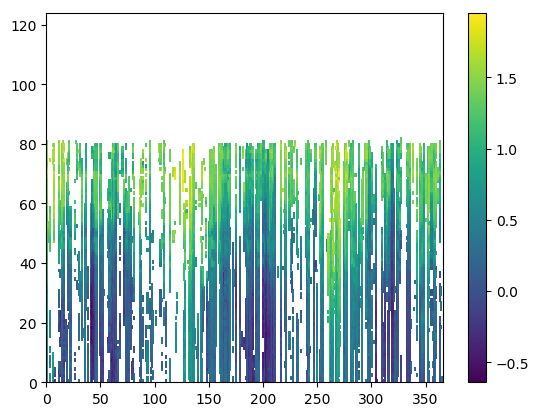

(PyObject <matplotlib.collections.PolyCollection object at 0x000000004A92C470>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000000069EB7F98>)

In [50]:
pcolor(errmap[:,:,340]),colorbar()
figure()
pcolor(spm[:,:,340]),colorbar()
figure()
pcolor(errmap[100,:,:]),colorbar()
figure()
pcolor(spm[100,:,:]),colorbar()



## Fuse the original data and the reconstruction to look at the effect

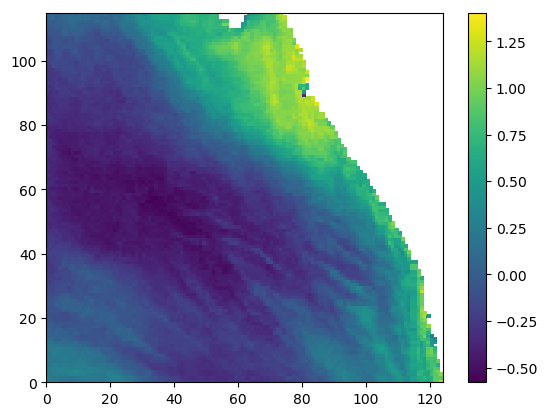

(PyObject <matplotlib.collections.PolyCollection object at 0x000000003F232518>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003F7E1D30>)

In [20]:
pcolor(XA[:,:,305]),colorbar()

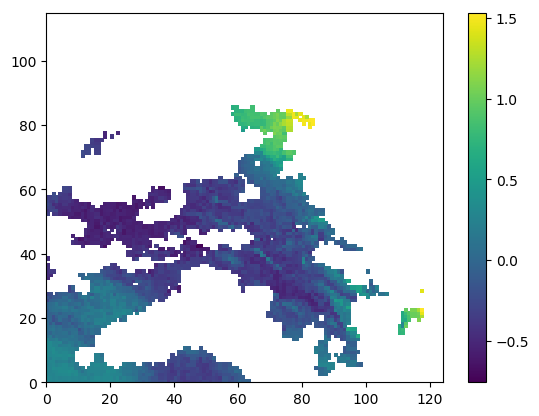

(PyObject <matplotlib.collections.PolyCollection object at 0x000000003F82DDD8>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003FB265F8>)

In [21]:
pcolor(spm[:,:,304]),colorbar()

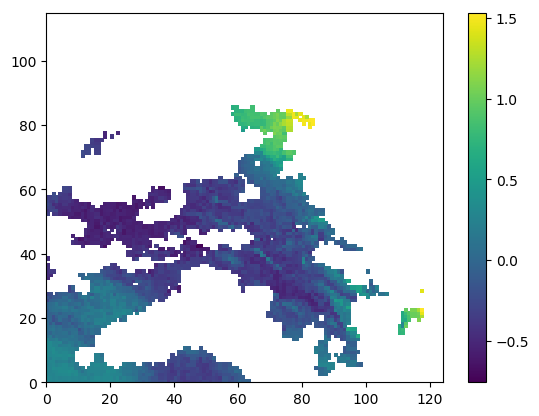

(PyObject <matplotlib.collections.PolyCollection object at 0x000000003FBAB828>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000000042724048>)

In [22]:
pcolor(spmf[:,:,304]),colorbar()

In [23]:
DINEOF_fuse!(spmf,XA,4)

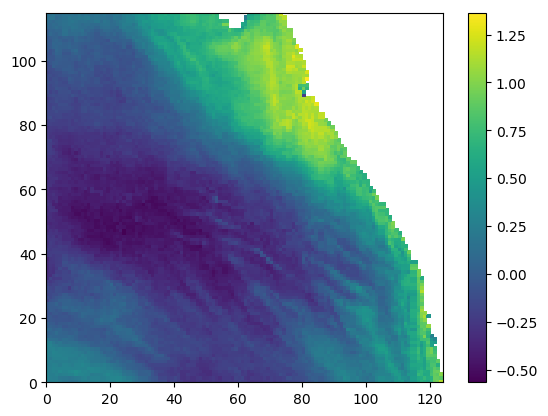

(PyObject <matplotlib.collections.PolyCollection object at 0x000000003B1BF438>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000000002564F60>)

In [24]:
pcolor(spmf[:,:,304]),colorbar()

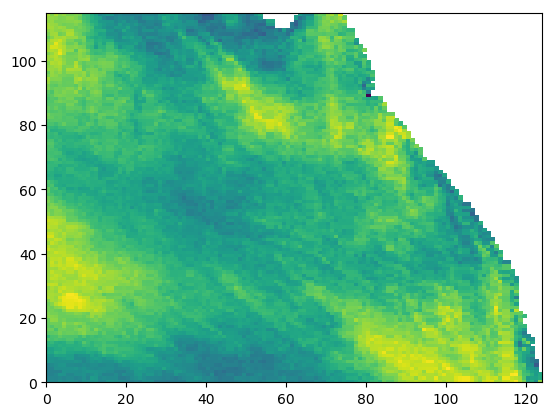

PyObject <matplotlib.collections.PolyCollection object at 0x000000005FE35EB8>

In [42]:
pcolor(U[:,:,end])

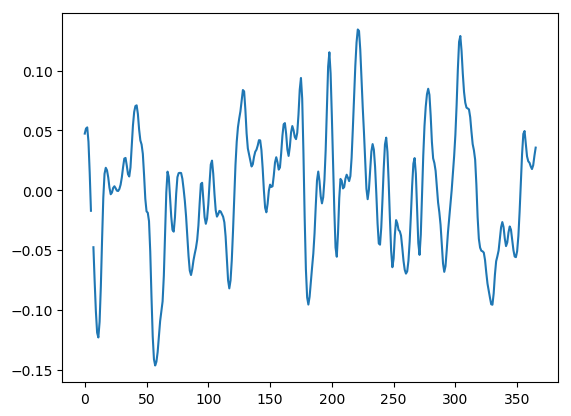

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005FF996D8>

In [41]:
plot(V[:,end])

In [38]:
S

11-element Array{Float64,1}:
 668.6444202092123  
 505.877622775704   
 123.18719989562805 
 106.22085123570916 
  96.95173126081161 
  87.35464619578808 
  72.12007304438093 
  68.78474125320518 
  58.06982770011159 
  51.993348887335465
  48.0862448918675  

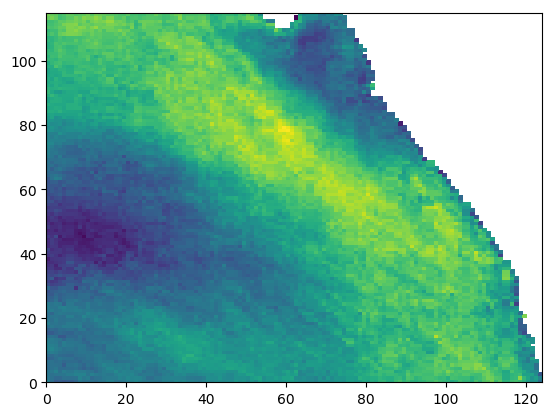

PyObject <matplotlib.collections.PolyCollection object at 0x000000003B26E668>

In [47]:
pcolor(U[:,:,5])